# Single File Calibration

**by Josh Dillon, Aaron Parsons, and Tyler Cox**, last updated October 3, 2022

This notebook is designed to infer as much information about the array from a single file, including pushing the calibration and RFI mitigation as far as possible 

Here's a set of links to skip to particular figures and tables:
# [• Figure 1: RFI Flagging](#Figure-1:-RFI-Flagging)
# [• Figure 2: Plot of autocorrelations with classifications](#Figure-2:-Plot-of-autocorrelations-with-classifications)
# [• Figure 3: Summary of antenna classifications prior to calibration](#Figure-3:-Summary-of-antenna-classifications-prior-to-calibration)
# [• Figure 4: Redundant calibration of a single baseline group](#Figure-4:-Redundant-calibration-of-a-single-baseline-group)
# [• Figure 5: chi^2 per antenna across the array](#Figure-5:-chi^2-per-antenna-across-the-array)
# [• Figure 6: Summary of antenna classifications after redundant calibration](#Figure-6:-Summary-of-antenna-classifications-after-redundant-calibration)
# [• Table 1: Complete summary of per antenna classifications](#Table-1:-Complete-summary-of-per-antenna-classifications)


In [1]:
import time
tstart = time.time()

In [73]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import numpy as np
from scipy import constants, interpolate
import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 1000)
from uvtools.plot import plot_antpos, plot_antclass
from hera_qm import ant_metrics, ant_class, xrfi
from hera_cal import io, utils, redcal, apply_cal, datacontainer, abscal
from hera_notebook_templates.data import DATA_PATH as HNBT_DATA
from IPython.display import display, HTML
import linsolve
from os import system
display(HTML("<style>.container { width:100% !important; }</style>"))
_ = np.seterr(all='ignore')  # get rid of red warnings
%config InlineBackend.figure_format = 'retina'
import hdf5plugin

In [3]:
# this enables better memory management on linux
import ctypes
def malloc_trim():
    try:
        ctypes.CDLL('libc.so.6').malloc_trim(0) 
    except OSError:
        pass

## Parse inputs and outputs

To use this notebook interactively, you will have to provide a sum filename path if none exists as an environment variable. All other parameters have reasonable default values.


In [16]:
# figure out whether to save results
SAVE_RESULTS = os.environ.get("SAVE_RESULTS", "TRUE").upper() == "TRUE"

# get infile names
#SUM_FILE = os.environ.get("SUM_FILE", None)
SUM_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.uvh5'  # If sum_file is not defined in the environment variables, define it here.
DIFF_FILE = SUM_FILE.replace('sum', 'diff')

# get outfilenames
AM_FILE = (SUM_FILE.replace('.uvh5', '.ant_metrics.hdf5') if SAVE_RESULTS else None)
ANTCLASS_FILE = (SUM_FILE.replace('.uvh5', '.ant_class.csv') if SAVE_RESULTS else None)
OMNICAL_FILE = (SUM_FILE.replace('.uvh5', '.omni.calfits') if SAVE_RESULTS else None)
OMNIVIS_FILE = (SUM_FILE.replace('.uvh5', '.omni_vis.uvh5') if SAVE_RESULTS else None)

for fname in ['SUM_FILE', 'DIFF_FILE', 'AM_FILE', 'ANTCLASS_FILE', 'OMNICAL_FILE', 'OMNIVIS_FILE']:
    print(f"{fname} = '{eval(fname)}'")

SUM_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.uvh5'
DIFF_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.diff.uvh5'
AM_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.ant_metrics.hdf5'
ANTCLASS_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.ant_class.csv'
OMNICAL_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.omni.calfits'
OMNIVIS_FILE = '/lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.omni_vis.uvh5'


### Parse settings
Load settings relating to the operation of the notebook, then print what was loaded (or default).

In [17]:
# parse plotting settings
PLOT = os.environ.get("PLOT", "TRUE").upper() == "TRUE"
if PLOT:
    %matplotlib inline

# parse omnical settings
OC_MAX_DIMS = int(os.environ.get("OC_MAX_DIMS", 4))
OC_MIN_DIM_SIZE = int(os.environ.get("OC_MIN_DIM_SIZE", 8))
OC_SKIP_OUTRIGGERS = os.environ.get("OC_SKIP_OUTRIGGERS", "TRUE").upper() == "TRUE"
OC_MAXITER = int(os.environ.get("OC_MAXITER", 50))
OC_MAX_RERUN = int(os.environ.get("OC_MAX_RERUN", 4))
OC_USE_GPU = os.environ.get("SAVE_RESULTS", "FALSE").upper() == "TRUE"

# parse RFI settings
RFI_DPSS_HALFWIDTH = float(os.environ.get("RFI_DPSS_HALFWIDTH", 300e-9))
RFI_NSIG = float(os.environ.get("RFI_NSIG", 6))

# print settings
for setting in ['PLOT', 'SAVE_RESULTS', 'OC_MAX_DIMS', 'OC_MIN_DIM_SIZE', 'OC_SKIP_OUTRIGGERS', 'OC_MAXITER', 'OC_MAX_RERUN',
                'OC_USE_GPU', 'RFI_DPSS_HALFWIDTH', 'RFI_NSIG']:
    print(f'{setting} = {eval(setting)}')

PLOT = True
SAVE_RESULTS = True
OC_MAX_DIMS = 4
OC_MIN_DIM_SIZE = 8
OC_SKIP_OUTRIGGERS = True
OC_MAXITER = 50
OC_MAX_RERUN = 4
OC_USE_GPU = False
RFI_DPSS_HALFWIDTH = 3e-07
RFI_NSIG = 6.0


### Parse bounds
Load settings related to classifying antennas as good, suspect, or bad, then print what was loaded (or default).

In [18]:
# ant_metrics bounds for low correlation / dead antennas
am_corr_bad = (0, float(os.environ.get("AM_CORR_BAD", 0.3)))
am_corr_suspect = (float(os.environ.get("AM_CORR_BAD", 0.3)), float(os.environ.get("AM_CORR_SUSPECT", 0.5)))

# ant_metrics bounds for cross-polarized antennas
am_xpol_bad = (-1, float(os.environ.get("AM_XPOL_BAD", -0.1)))
am_xpol_suspect = (float(os.environ.get("AM_XPOL_BAD", -0.1)), float(os.environ.get("AM_XPOL_SUSPECT", 0)))

# bounds on zeros in spectra
good_zeros_per_eo_spectrum = (0, int(os.environ.get("MAX_ZEROS_PER_EO_SPEC_GOOD", 2)))
suspect_zeros_per_eo_spectrum = (0, int(os.environ.get("MAX_ZEROS_PER_EO_SPEC_SUSPECT", 8)))

# bounds on autocorrelation power
auto_power_good = (float(os.environ.get("AUTO_POWER_GOOD_LOW", 5)), float(os.environ.get("AUTO_POWER_GOOD_HIGH", 30)))
auto_power_suspect = (float(os.environ.get("AUTO_POWER_SUSPECT_LOW", 1)), float(os.environ.get("AUTO_POWER_SUSPECT_HIGH", 50)))

# bounds on autocorrelation slope
auto_slope_good = (float(os.environ.get("AUTO_SLOPE_GOOD_LOW", -0.4)), float(os.environ.get("AUTO_SLOPE_GOOD_HIGH", 0.4)))
auto_slope_suspect = (float(os.environ.get("AUTO_SLOPE_SUSPECT_LOW", -0.6)), float(os.environ.get("AUTO_SLOPE_SUSPECT_HIGH", 0.6)))

# bounds on autocorrelation RFI
auto_rfi_good = (0, float(os.environ.get("AUTO_RFI_GOOD", 0.01)))
auto_rfi_suspect = (0, float(os.environ.get("AUTO_RFI_SUSPECT", 0.02)))

# bounds on autocorrelation shape
auto_shape_good = (0, float(os.environ.get("AUTO_SHAPE_GOOD", 0.0625)))
auto_shape_suspect = (0, float(os.environ.get("AUTO_SHAPE_SUSPECT", 0.125)))

# bounds on chi^2 per antenna in omnical
oc_cspa_good = (0, float(os.environ.get("OC_CSPA_GOOD", 3)))
oc_cspa_suspect = (float(os.environ.get("OC_CSPA_GOOD", 3)), float(os.environ.get("OC_CSPA_SUSPECT", 6)))

# print bounds
for bound in ['am_corr_bad', 'am_corr_suspect', 'am_xpol_bad', 'am_xpol_suspect', 
              'good_zeros_per_eo_spectrum', 'suspect_zeros_per_eo_spectrum',
              'auto_power_good', 'auto_power_suspect', 'auto_slope_good', 'auto_slope_suspect',
              'auto_rfi_good', 'auto_rfi_suspect', 'auto_shape_good', 'auto_shape_suspect',
              'oc_cspa_good', 'oc_cspa_suspect']:
    print(f'{bound} = {eval(bound)}')

am_corr_bad = (0, 0.3)
am_corr_suspect = (0.3, 0.5)
am_xpol_bad = (-1, -0.1)
am_xpol_suspect = (-0.1, 0.0)
good_zeros_per_eo_spectrum = (0, 2)
suspect_zeros_per_eo_spectrum = (0, 8)
auto_power_good = (5.0, 30.0)
auto_power_suspect = (1.0, 50.0)
auto_slope_good = (-0.4, 0.4)
auto_slope_suspect = (-0.6, 0.6)
auto_rfi_good = (0, 0.01)
auto_rfi_suspect = (0, 0.02)
auto_shape_good = (0, 0.0625)
auto_shape_suspect = (0, 0.125)
oc_cspa_good = (0, 3.0)
oc_cspa_suspect = (3.0, 6.0)


## Load sum and diff data

In [19]:
hd = io.HERADataFastReader(SUM_FILE)
data, _, _ = hd.read(read_flags=False, read_nsamples=False)
hd_diff = io.HERADataFastReader(DIFF_FILE)
diff_data, _, _ = hd_diff.read(read_flags=False, read_nsamples=False)

In [20]:
ants = sorted(set([ant for bl in hd.bls for ant in utils.split_bl(bl)]))
auto_bls = [bl for bl in data if (bl[0] == bl[1]) and (utils.split_pol(bl[2])[0] == utils.split_pol(bl[2])[1])]
antpols = sorted(set([ant[1] for ant in ants]))

In [21]:
# print basic information about the file
print(f'File: {SUM_FILE}')
print(f'JDs: {hd.times} ({np.median(np.diff(hd.times)) * 24 * 3600:.5f} s integrations)')
print(f'LSTS: {hd.lsts * 12 / np.pi } hours')
print(f'Frequencies: {len(hd.freqs)} {np.median(np.diff(hd.freqs)) / 1e6:.5f} MHz channels from {hd.freqs[0] / 1e6:.5f} to {hd.freqs[-1] / 1e6:.5f} MHz')
print(f'Antennas: {len(hd.data_ants)}')
print(f'Polarizations: {hd.pols}')

File: /lustre/aoc/projects/hera/H6C/2459852/zen.2459852.49983.sum.uvh5
JDs: [2459852.49977029 2459852.49988214] (9.66368 s integrations)
LSTS: [2.00454854 2.00724025] hours
Frequencies: 1536 0.12207 MHz channels from 46.92078 to 234.29871 MHz
Antennas: 180
Polarizations: ['nn', 'ee', 'ne', 'en']


## Classify good, suspect, and bad antpols

### Run `ant_metrics`

This classifies antennas as cross-polarized, low-correlation, or dead. Such antennas are excluded from any calibration.

In [22]:
am = ant_metrics.AntennaMetrics(SUM_FILE, DIFF_FILE, sum_data=data, diff_data=diff_data)
am.iterative_antenna_metrics_and_flagging(crossCut=am_xpol_bad[1], deadCut=am_corr_bad[1])
am.all_metrics = {}  # this saves time and disk by getting rid of per-iteration information we never use
if SAVE_RESULTS:
    am.save_antenna_metrics(AM_FILE, overwrite=True)

In [23]:
# Turn ant metrics into classifications
totally_dead_ants = [ant for ant, i in am.removal_iteration.items() if i == -1]
am_totally_dead = ant_class.AntennaClassification(good=[ant for ant in ants if ant not in totally_dead_ants], bad=totally_dead_ants)
am_corr = ant_class.antenna_bounds_checker(am.final_metrics['corr'], bad=[am_corr_bad], suspect=[am_corr_suspect], good=[(0, 1)])
am_xpol = ant_class.antenna_bounds_checker(am.final_metrics['corrXPol'], bad=[am_xpol_bad], suspect=[am_xpol_suspect], good=[(-1, 1)])
ant_metrics_class = am_totally_dead + am_corr + am_xpol

### Classify antennas responsible for 0s in visibilities as bad: 

This classifier looks for X-engine failure or packet loss specific to an antenna which causes either the even visibilities (or the odd ones, or both) to be 0s. 

In [24]:
zeros_class = ant_class.even_odd_zeros_checker(data, diff_data, good=good_zeros_per_eo_spectrum, suspect=suspect_zeros_per_eo_spectrum)

In [25]:
# delete diffs to save memory
del diff_data, hd_diff
malloc_trim()

### Examine and classify autocorrelation power, slope, and RFI occpancy

These classifiers look for antennas with too high or low power, to steep a slope, or too much excess RFI.

In [26]:
auto_power_class = ant_class.auto_power_checker(data, good=auto_power_good, suspect=auto_power_suspect)
auto_slope_class = ant_class.auto_slope_checker(data, good=auto_slope_good, suspect=auto_slope_suspect, edge_cut=100, filt_size=17)
cache = {}
auto_rfi_class = ant_class.auto_rfi_checker(data, good=auto_rfi_good, suspect=auto_rfi_suspect, 
                                            filter_half_widths=[RFI_DPSS_HALFWIDTH], nsig=RFI_NSIG, cache=cache)
auto_class = auto_power_class + auto_slope_class + auto_rfi_class

In [27]:
del cache
malloc_trim()

### Find and flag RFI

In [28]:
# Compute int_count for all unflagged autocorrelations averaged together
int_time = 24 * 3600 * np.median(np.diff(data.times_by_bl[auto_bls[0][0:2]]))
chan_res = np.median(np.diff(data.freqs))
final_class = ant_metrics_class + zeros_class + auto_class
int_count = int(int_time * chan_res) * (len(final_class.good_ants) + len(final_class.suspect_ants))
avg_auto = {(-1, -1, 'ee'): np.mean([data[bl] for bl in auto_bls if final_class[utils.split_bl(bl)[0]] != 'bad'], axis=0)}
# Flag RFI first with channel differences and then with DPSS
antenna_flags, _ = xrfi.flag_autos(avg_auto, int_count=int_count, nsig=(RFI_NSIG * 5))
_, rfi_flags = xrfi.flag_autos(avg_auto, int_count=int_count, flag_method='dpss_flagger',
                               flags=antenna_flags, freqs=data.freqs, filter_centers=[0],
                               filter_half_widths=[RFI_DPSS_HALFWIDTH], eigenval_cutoff=[1e-9], nsig=RFI_NSIG)
malloc_trim()

RuntimeError: filter weights array has incorrect shape.

In [34]:
def rfi_plot():
    plt.figure(figsize=(12, 5), dpi=100)
    plt.semilogy(hd.freqs / 1e6, np.where(rfi_flags, np.nan, avg_auto[(-1, -1, 'ee')])[1], label = 'Average Good or Suspect Autocorrelation', zorder=100)
    plt.semilogy(hd.freqs / 1e6, np.where(False, np.nan, avg_auto[(-1, -1, 'ee')])[1], 'r', lw=.5, label=f'{np.sum(rfi_flags[0])} Channels Flagged for RFI')
    plt.legend()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Uncalibrated Autocorrelation')
    plt.tight_layout()

# *Figure 1: RFI Flagging*

This figure shows RFI identified using the average of all autocorrelations---excluding bad antennas---for the first integration in the file. 

In [35]:
rfi_plot()

NameError: name 'rfi_flags' is not defined

<Figure size 1200x500 with 0 Axes>

In [36]:
def autocorr_plot(cls):    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100, sharey=True, gridspec_kw={'wspace': 0})
    labels = []
    colors = ['darkgreen', 'goldenrod', 'maroon']
    for ax, pol in zip(axes, antpols):
        for ant in cls.ants:
            if ant[1] == pol:
                color = colors[cls.quality_classes.index(cls[ant])]
                ax.semilogy(np.mean(data[utils.join_bl(ant, ant)], axis=0), color=color, lw=.5)
        ax.set_xlabel('Channel', fontsize=12)
        ax.set_title(f'{utils.join_pol(pol, pol)}-Polarized Autos')

    axes[0].set_ylabel('Raw Autocorrelation', fontsize=12)
    axes[1].legend([matplotlib.lines.Line2D([0], [0], color=color) for color in colors], 
                   [cls.capitalize() for cls in auto_class.quality_classes], ncol=1, fontsize=12, loc='upper right', framealpha=1)
    plt.tight_layout()

### Classify antennas based on shapes, excluding RFI-contamined channels

In [37]:
auto_shape_class = ant_class.auto_shape_checker(data, good=auto_shape_good, suspect=auto_shape_suspect,
                                                flag_spectrum=np.sum(rfi_flags, axis=0).astype(bool), antenna_class=final_class)
auto_class += auto_shape_class

NameError: name 'rfi_flags' is not defined

# *Figure 2: Plot of autocorrelations with classifications*
This figure shows a plot of all autocorrelations in the array, split by polarization. 
Antennas are classified based on their autocorrelations into good, suspect, and bad, by examining power, slope, and RFI-occupancy. 

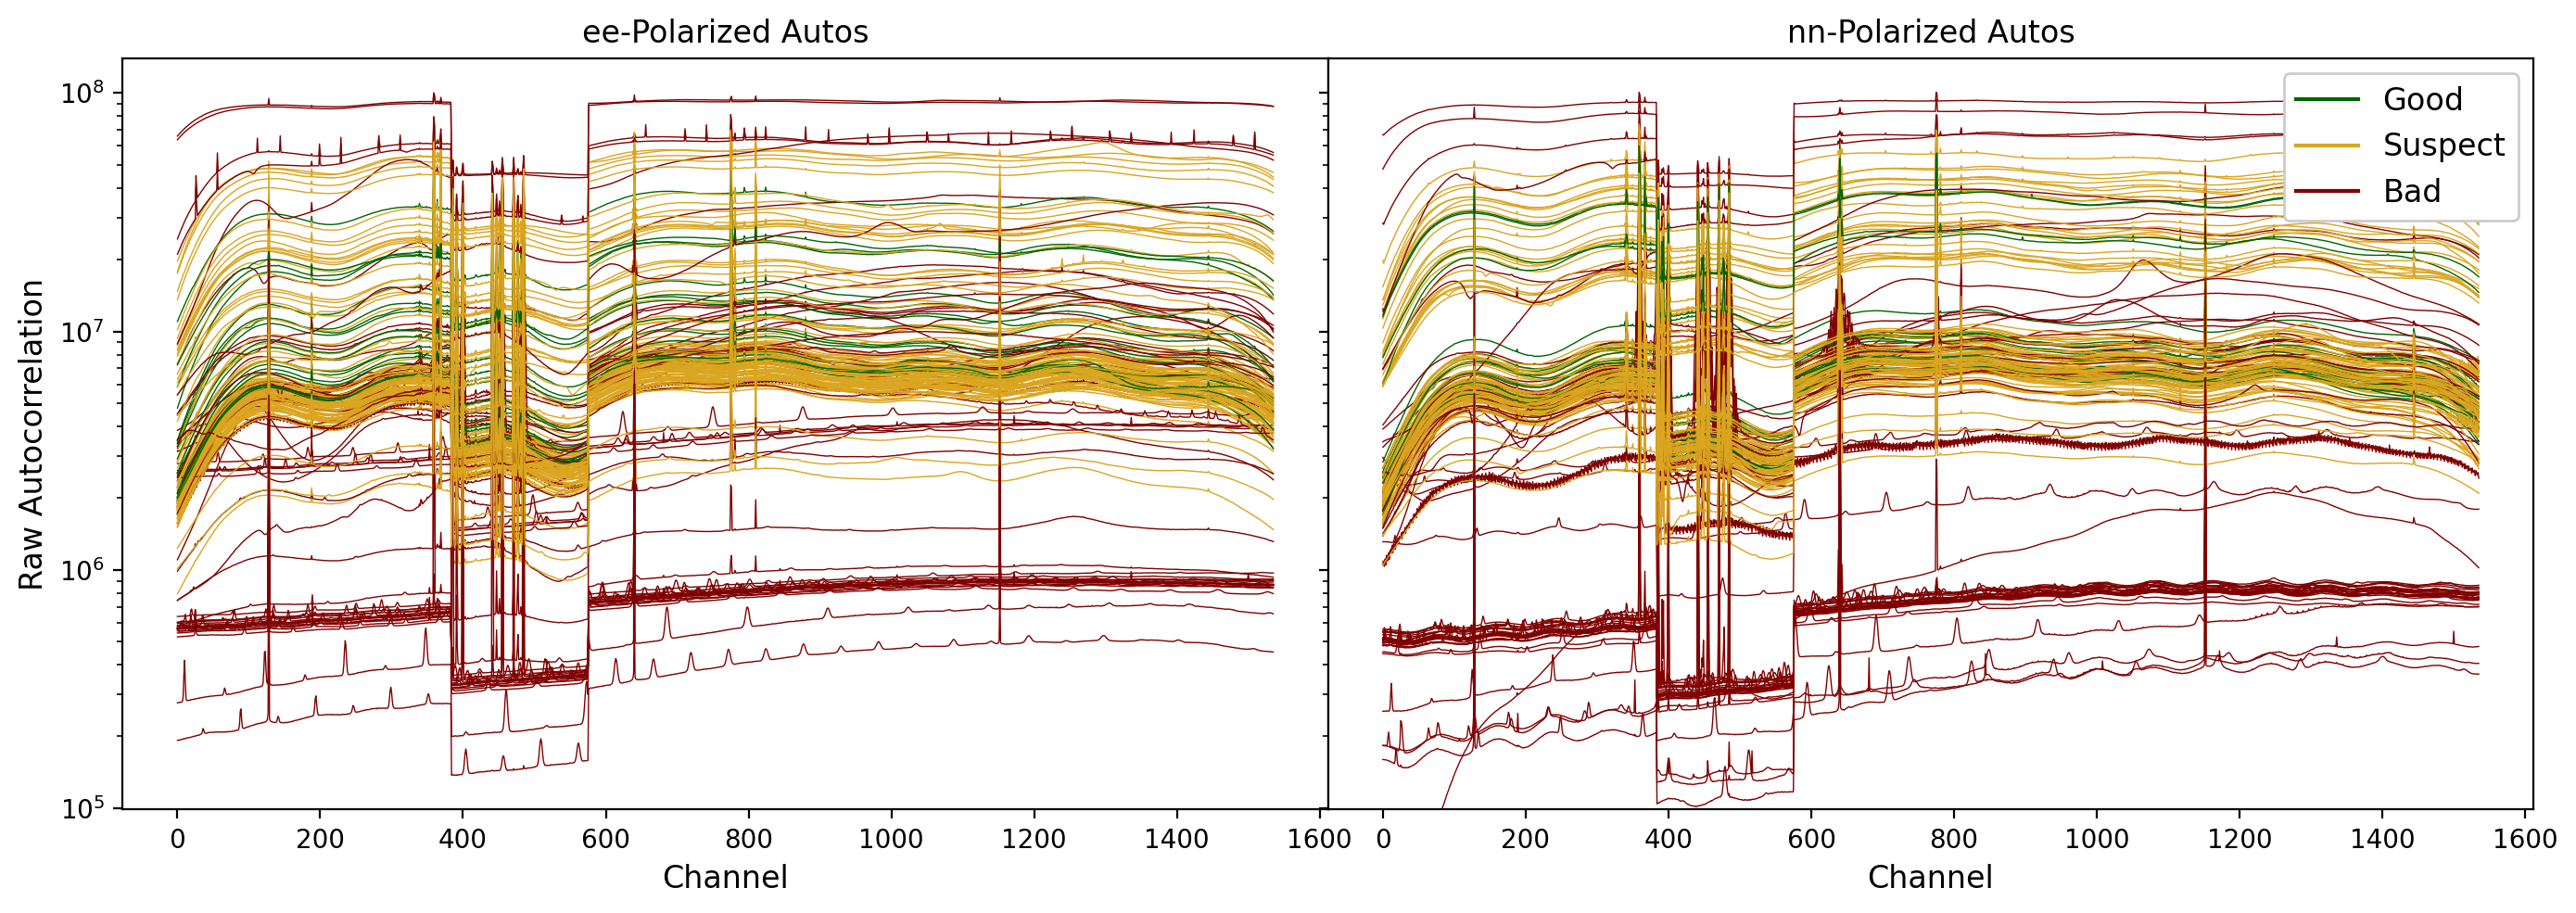

In [38]:
if PLOT: autocorr_plot(auto_class)

### Summarize antenna classification prior to redundant-baseline calibration

In [42]:
final_class = ant_metrics_class + zeros_class + auto_class

In [43]:
def array_class_plot(cls):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    plot_antclass(hd.antpos, cls, ax=axes[0], ants=[ant for ant in hd.data_ants if ant < 320], legend=False, title='HERA Core')
    plot_antclass(hd.antpos, cls, ax=axes[1], ants=[ant for ant in hd.data_ants if ant >= 320], radius=50, title='Outriggers')

# *Figure 3: Summary of antenna classifications prior to calibration*
This figure shows the location and classification of all antennas prior to calibration. 
Antennas are split along the diagonal, with ee-polarized antpols represented by the southeast half of each antenna and nn-polarized antpols represented by the northwest half.
Outriggers are split from the core and shown at exaggerated size in the right-hand panel. This classification includes `ant_metrics`, a count of the zeros in the even or odd visibilities, and autocorrelation power, slope, and RFI occupancy.
An antenna classified as bad in *any* classification will be considered bad. 
An antenna marked as suspect *any* in any classification will be considered suspect unless it is also classified as bad elsewhere.

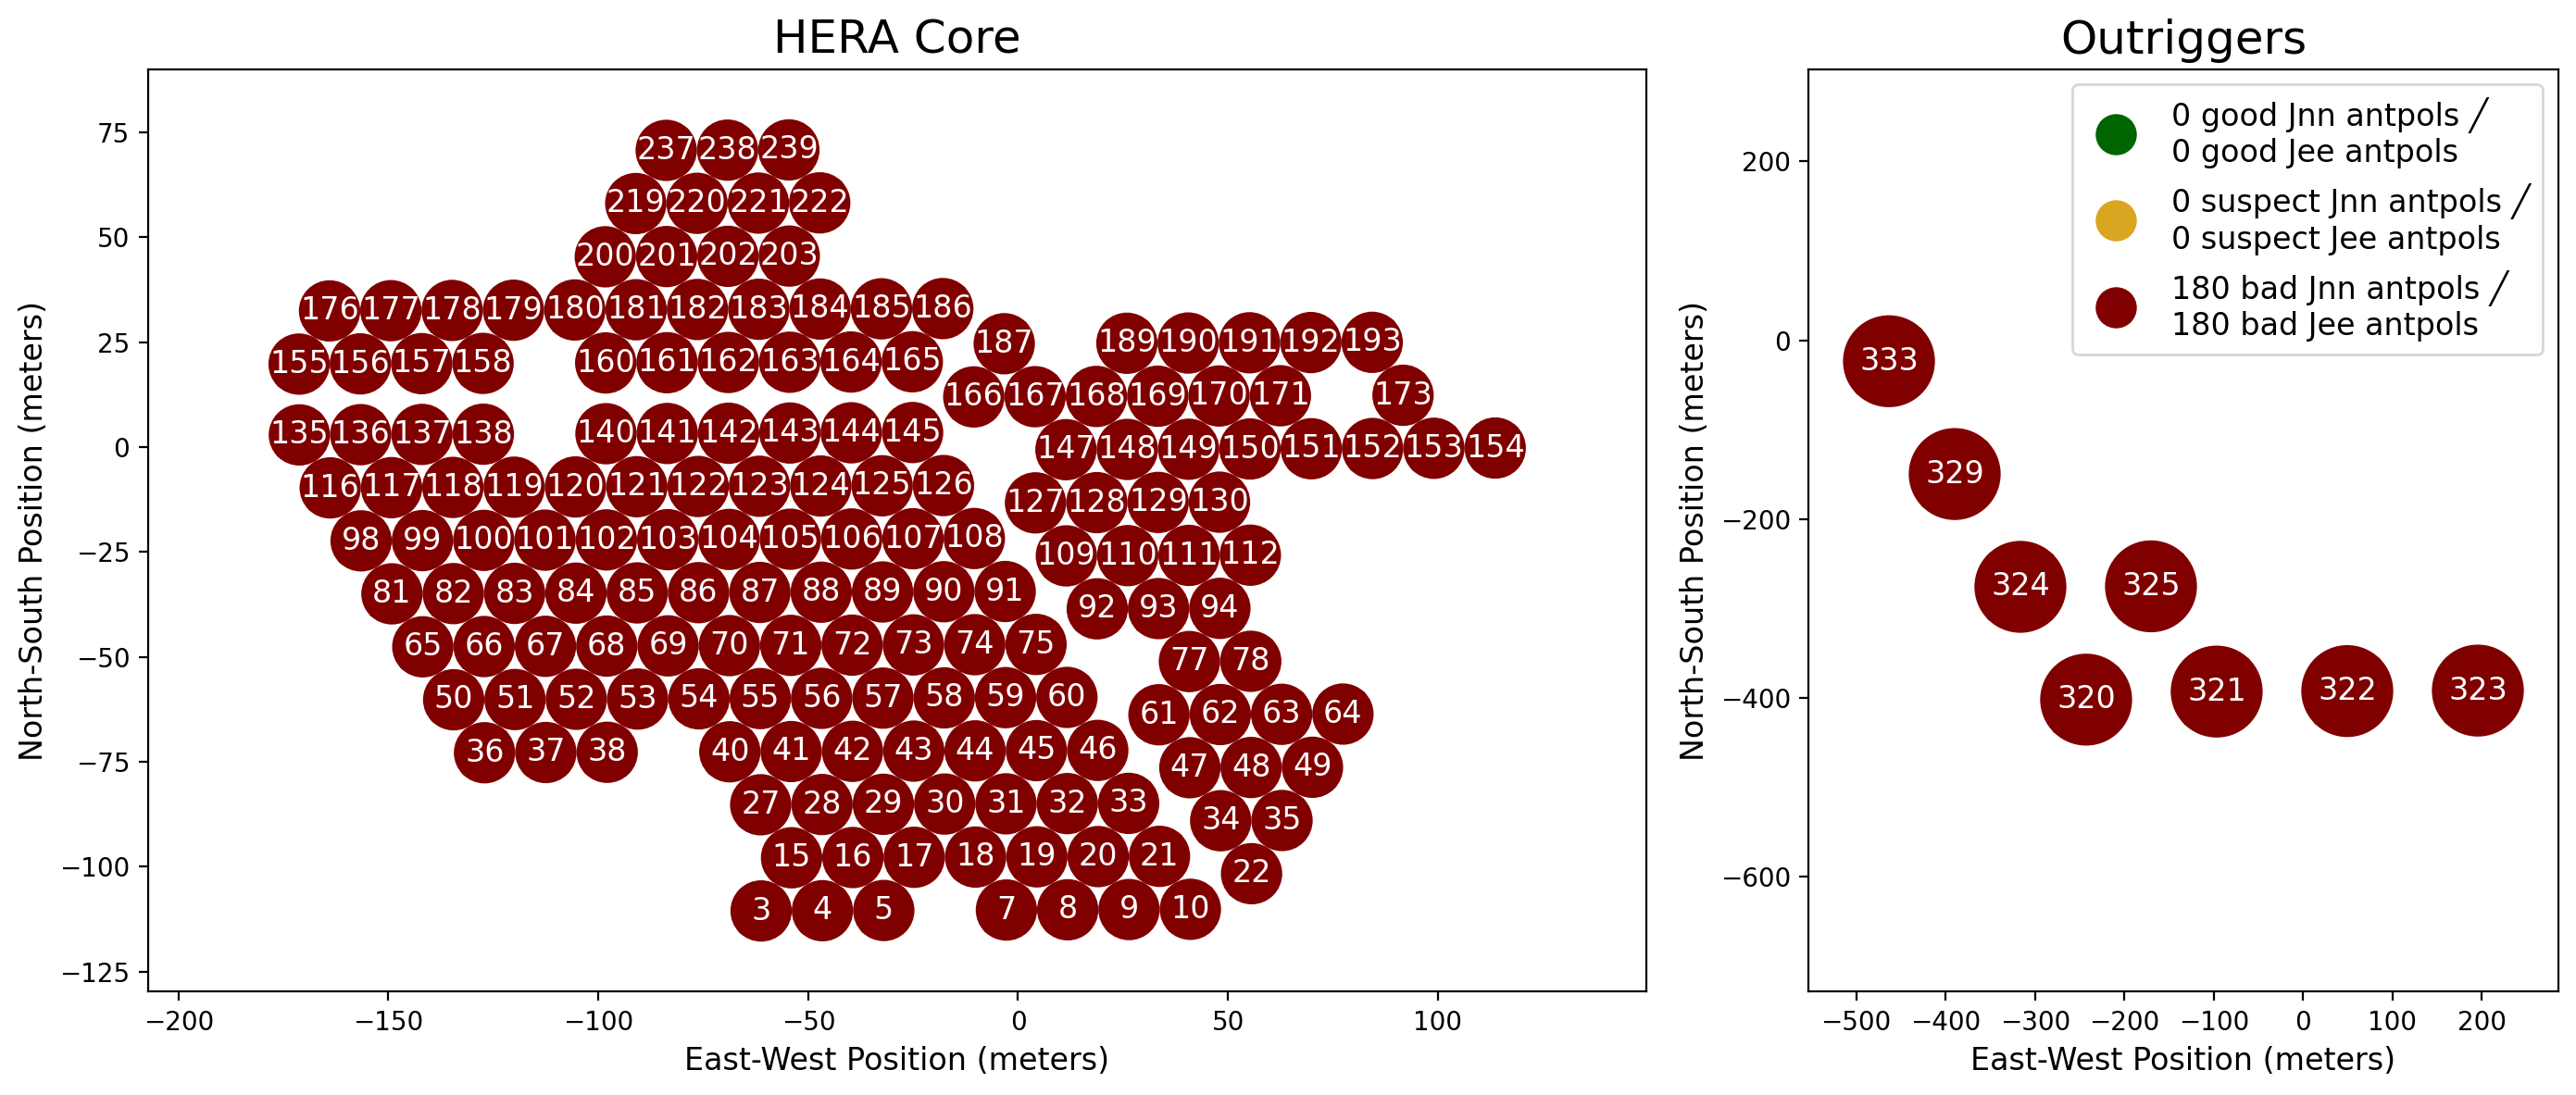

In [44]:
if PLOT: array_class_plot(final_class)

## Perform redundant-baseline calibration

In [45]:
def classify_off_grid(reds, all_ants):
    '''Returns AntennaClassification of all_ants where good ants are in reds while bad ants are not.'''
    ants_in_reds = set([ant for red in reds for bl in red for ant in utils.split_bl(bl)])
    on_grid = [ant for ant in all_ants if ant in ants_in_reds]
    off_grid = [ant for ant in all_ants if ant not in ants_in_reds]
    return ant_class.AntennaClassification(good=on_grid, bad=off_grid)

### Perform iterative `redcal`

In [47]:
if final_class.good_ants or final_class.suspect_ants:
    redcal_start = time.time()
    rc_settings = {'max_dims': OC_MAX_DIMS, 'oc_conv_crit': 1e-10, 'gain': 0.4, 
                   'oc_maxiter': OC_MAXITER, 'check_after': OC_MAXITER, 'use_gpu': OC_USE_GPU}

    # figure out and filter reds and classify antennas based on whether or not they are on the main grid
    reds = redcal.get_reds(hd.data_antpos, pols=['ee', 'nn'], pol_mode='2pol')
    reds = redcal.filter_reds(reds, ex_ants=final_class.bad_ants, max_dims=OC_MAX_DIMS, min_dim_size=OC_MIN_DIM_SIZE)
    if OC_SKIP_OUTRIGGERS:
        reds = redcal.filter_reds(reds, ex_ants=[ant for ant in ants if ant[0] >= 320])
    redcal_class = classify_off_grid(reds, ants)

    # perform first stage of redundant calibration, 
    cal = redcal.redundantly_calibrate(data, reds, **rc_settings)
    malloc_trim()
    max_dly = np.max(np.abs(list(cal['fc_meta']['dlys'].values())))
    med_cspa = {ant: np.median(cal['chisq_per_ant'][ant]) for ant in cal['chisq_per_ant']}
    cspa_class = ant_class.antenna_bounds_checker(med_cspa, good=np.array(oc_cspa_good)*5, suspect=np.array(oc_cspa_suspect)*5, bad=(0, np.inf))
    redcal_class += cspa_class
    print(f'Removing {cspa_class.bad_ants} for high chi^2.')

    # iteratively rerun redundant calibration
    for i in range(OC_MAX_RERUN):
        # build RedDataContainer of old visibility solution
        prior_vis = datacontainer.RedDataContainer(cal['v_omnical'], reds)

        # refilter reds and update classification to reflect new off-grid ants, if any
        reds = redcal.filter_reds(reds, ex_ants=(final_class + redcal_class).bad_ants, max_dims=OC_MAX_DIMS, min_dim_size=OC_MIN_DIM_SIZE)
        reds = sorted(reds, key=len, reverse=True)
        redcal_class += classify_off_grid(reds, ants)
        ants_in_reds = set([ant for red in reds for bl in red for ant in utils.split_bl(bl)])    

        # re-run redundant calibration using previous solution, updating bad and suspicious antennas
        prior_sol = redcal.RedSol(reds, gains={ant: cal['g_omnical'][ant] for ant in ants_in_reds}, 
                                  vis={red[0]: prior_vis[red[0]] for red in reds})    
        cal = redcal.redundantly_calibrate(data, reds, prior_firstcal=prior_sol.gains, prior_sol=prior_sol, **rc_settings)
        malloc_trim()
        med_cspa = {ant: np.median(cal['chisq_per_ant'][ant]) for ant in cal['chisq_per_ant']}
        cspa_class = ant_class.antenna_bounds_checker(med_cspa, good=oc_cspa_good, suspect=oc_cspa_suspect, bad=(0, np.inf))
        redcal_class += cspa_class
        print(f'Removing {cspa_class.bad_ants} for high chi^2.')
        if len(cspa_class.bad_ants) == 0:
            break  # no new antennas to flag
    final_class += redcal_class
    print(f'Finished redcal in {(time.time() - redcal_start) / 60:.2f} minutes.')
else:
    print("No good ants, so no need to run redcal...")

No good ants, so no need to run redcal...


### Fix the `firstcal` delay slope degeneracy using RFI transmitters

In [49]:
# find channels clearly contaminated by RFI
not_bad_ants = [ant for ant in final_class.ants if final_class[ant] != 'bad']
if not_bad_ants:
    chan_flags = np.mean([xrfi.detrend_medfilt(data[utils.join_bl(ant, ant)], Kf=8, Kt=2) for ant in not_bad_ants], axis=(0, 1)) > 5

    # hardcoded RFI transmitters and their headings
    # channel: frequency (Hz), heading (rad), chi^2
    phs_sol = {359: ( 90744018.5546875, 0.7853981, 23.3),
               360: ( 90866088.8671875, 0.7853981, 10.8),
               385: ( 93917846.6796875, 0.7853981, 27.3),
               386: ( 94039916.9921875, 0.7853981, 18.1),
               400: ( 95748901.3671875, 6.0632738, 24.0),
               441: (100753784.1796875, 0.7853981, 21.7),
               442: (100875854.4921875, 0.7853981, 19.4),
               455: (102462768.5546875, 6.0632738, 18.8),
               456: (102584838.8671875, 6.0632738,  8.8),
               471: (104415893.5546875, 0.7853981, 13.3),
               484: (106002807.6171875, 6.0632738, 21.2),
               485: (106124877.9296875, 6.0632738,  4.0),
              1181: (191085815.4296875, 0.7853981, 26.3),
              1182: (191207885.7421875, 0.7853981, 27.0),
              1183: (191329956.0546875, 0.7853981, 25.6),
              1448: (223678588.8671875, 2.6075219, 25.7),
              1449: (223800659.1796875, 2.6075219, 22.6),
              1450: (223922729.4921875, 2.6075219, 11.6),
              1451: (224044799.8046875, 2.6075219,  5.9),
              1452: (224166870.1171875, 2.6075219, 22.6),
              1510: (231246948.2421875, 0.1068141, 23.9)}
    rfi_chans = [chan for chan in phs_sol if chan_flags[chan]]
    print('Channels used for delay-slope calibration with RFI:', rfi_chans)
    rfi_angles = np.array([phs_sol[chan][1] for chan in rfi_chans])
    rfi_headings = np.array([np.cos(rfi_angles), np.sin(rfi_angles), np.zeros_like(rfi_angles)])
    rfi_chisqs = np.array([phs_sol[chan][2] for chan in rfi_chans])

In [51]:
# resolve firstcal degeneracy with delay slopes set by RFI transmitters, update cal
if not_bad_ants:
    RFI_dly_slope_gains = abscal.RFI_delay_slope_cal(reds, hd.antpos, cal['v_omnical'], hd.freqs, rfi_chans, rfi_headings, rfi_wgts=rfi_chisqs**-.5,
                                                     min_tau=-max_dly, max_tau=max_dly, delta_tau=0.1e-9, return_gains=True, gain_ants=cal['g_omnical'].keys())
    cal['g_omnical'] = {ant: g * RFI_dly_slope_gains[ant] for ant, g in cal['g_omnical'].items()}
    apply_cal.calibrate_in_place(cal['v_omnical'], RFI_dly_slope_gains)
    malloc_trim()

### Perform approximate absolute amplitude calibration using a model of autocorrelations

In [52]:
# Load simulated and then downsampled model of autocorrelations that includes receiver noise, then interpolate to upsample
hd_model = io.HERADataFastReader(f'{HNBT_DATA}/SSM_autocorrelations_downsampled.uvh5')
model, _, _ = hd_model.read(read_flags=False, read_nsamples=False)
per_pol_interpolated_model = {}
for bl in model:
    sorted_lsts, lst_indices = np.unique(model.lsts, return_index=True)
    periodic_model = np.vstack([model[bl][lst_indices, :], model[bl][lst_indices[0], :]])
    periodic_lsts = np.append(sorted_lsts, sorted_lsts[0] + 2 * np.pi)
    lst_interpolated = interpolate.CubicSpline(periodic_lsts, periodic_model, axis=0, bc_type='periodic')(data.lsts)
    per_pol_interpolated_model[bl[2]] = interpolate.CubicSpline(model.freqs, lst_interpolated, axis=1)(data.freqs)
model = {bl: per_pol_interpolated_model[bl[2]] for bl in auto_bls if utils.split_bl(bl)[0] not in final_class.bad_ants}    

In [54]:
# Run abscal and update omnical gains with abscal gains
if not_bad_ants:
    redcaled_autos = datacontainer.DataContainer({bl: np.array(data[bl]) for bl in auto_bls if utils.split_bl(bl)[0] not in final_class.bad_ants})
    apply_cal.calibrate_in_place(redcaled_autos, cal['g_omnical'])
    g_abscal = abscal.abs_amp_lincal(model, redcaled_autos, verbose=False, return_gains=True, gain_ants=cal['g_omnical'])
    cal['g_omnical'] = {ant: g * g_abscal[ant] for ant, g in cal['g_omnical'].items()}
    apply_cal.calibrate_in_place(cal['v_omnical'], g_abscal)

In [55]:
del hd_model, model, redcaled_autos
malloc_trim()

In [56]:
def redundant_group_plot():
    fig, axes = plt.subplots(2, 2, figsize=(14, 6), dpi=100, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, pol in enumerate(['ee', 'nn']):
        reds_here = redcal.get_reds(hd.data_antpos, pols=[pol], pol_mode='1pol')
        red = sorted(redcal.filter_reds(reds_here, ex_ants=final_class.bad_ants), key=len, reverse=True)[0]
        rc_data = {bl: np.array(data[bl]) for bl in red}
        apply_cal.calibrate_in_place(rc_data, cal['g_omnical'])
        for bl in red:
            axes[0, i].plot(hd.freqs/1e6, np.angle(rc_data[bl][0]), alpha=.5, lw=.5)
            axes[1, i].semilogy(hd.freqs/1e6, np.abs(rc_data[bl][0]), alpha=.5, lw=.5)
        axes[0, i].plot(hd.freqs / 1e6, np.angle(cal['v_omnical'][red[0]][0]), lw=1, c='k')
        axes[1, i].semilogy(hd.freqs / 1e6, np.abs(cal['v_omnical'][red[0]][0]), lw=1, c='k', label=f'Baseline Group:\n{red[0]}')
        axes[1, i].set_xlabel('Frequency (MHz)')
        axes[1, i].legend(loc='upper right')
    axes[0, 0].set_ylabel('Visibility Phase (radians)')
    axes[1, 0].set_ylabel('Visibility Amplitude (Jy)')
    plt.tight_layout()

# *Figure 4: Redundant calibration of a single baseline group*
The results of a redundant-baseline calibration of a single integration and a single group, the one with the highest redundancy in each polarization after antenna classification and excision based on the above, plus the removal of antennas with high chi^2 per antenna. The black line is the redundant visibility solution. Each thin colored line is a different baseline group. Phases are shown in the top row, amplitudes in the bottom, ee-polarized visibilities in the left column, and nn-polarized visibilities in the right.

In [58]:
if PLOT and not_bad_ants: redundant_group_plot()

### Attempt to calibrate some flagged antennas
This attempts to calibrate bad antennas using information from good or suspect antennas without allowing bad antennas to affect their calibration. 
However antennas flagged for `ant_metrics` or lots of zeros in the even or odd visibilities are considered beyond saving. 
Likewise, some antennas would add extra degeneracies (controlled by `OC_MAX_DIMS`, `OC_MIN_DIM_SIZE`, and `OC_SKIP_OUTRIGGERS`) are excluded. 

In [59]:
if not_bad_ants:
    expand_start = time.time()
    expanded_reds = redcal.get_reds(hd.data_antpos, pols=['ee', 'nn'], pol_mode='2pol')
    expanded_reds = redcal.filter_reds(expanded_reds, ex_ants=(ant_metrics_class + zeros_class).bad_ants, max_dims=OC_MAX_DIMS, min_dim_size=OC_MIN_DIM_SIZE)
    if OC_SKIP_OUTRIGGERS:
        expanded_reds = redcal.filter_reds(expanded_reds, ex_ants=[ant for ant in ants if ant[0] >= 320])
    nsamples = datacontainer.DataContainer({bl: np.ones_like(data[bl], dtype=float) for bl in data})
    redcal.expand_omni_sol(cal, expanded_reds, data, nsamples)
    malloc_trim()
    print(f'Finished expanding omni_sol in {(time.time() - expand_start) / 60:.2f} minutes.')

In [60]:
def array_chisq_plot():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)
    for ax, pol in zip(axes, ['ee', 'nn']):
        ants_to_plot = set([ant for ant in cal['chisq_per_ant'] if utils.join_pol(ant[1], ant[1]) == pol])
        cspas = [np.median(cal['chisq_per_ant'][ant]) for ant in ants_to_plot]
        xpos = [hd.antpos[ant[0]][0] for ant in ants_to_plot]
        ypos = [hd.antpos[ant[0]][1] for ant in ants_to_plot]
        scatter = ax.scatter(xpos, ypos, s=300, c=cspas, norm=matplotlib.colors.LogNorm(vmin=1, vmax=oc_cspa_suspect[1]))
        for ant in ants_to_plot:
            ax.text(hd.antpos[ant[0]][0], hd.antpos[ant[0]][1], ant[0], va='center', ha='center', fontsize=9,
                    c=('r' if ant in final_class.bad_ants else 'w'))
        plt.colorbar(scatter, ax=ax, extend='both')
        ax.axis('equal')
        ax.set_xlabel('East-West Position (meters)')
        ax.set_ylabel('North-South Position (meters)')
        ax.set_title(f'{pol}-pol $\\chi^2$ / Antenna (Red is Flagged)')
    plt.tight_layout()

# *Figure 5: chi^2 per antenna across the array*

This plot shows median (taken over time and frequency) of the normalized chi^2 per antenna. 
The expectation value for this quantity when the array is perfectly redundant is 1.0. 
Antennas that are classified as bad for any reason have their numbers shown in red. 
Some of those antennas were classified as bad during redundant calibration for high chi^2. 
Some of those antennas were originally excluded from redundant calibration because they were classified as bad earlier for some reason. 
See [here for more details.](#Attempt-to-calibrate-some-flagged-antennas)
Note that the color scale saturates at below 1 and above 10. 

In [62]:
if PLOT and not_bad_ants: array_chisq_plot()

In [63]:
def array_class_after_redcal_plot():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, gridspec_kw={'width_ratios': [2, 1]})
    plot_antclass(hd.antpos, final_class, ax=axes[0], ants=[ant for ant in hd.data_ants if ant < 320], legend=False, title='HERA Core, Post-Redcal')
    plot_antclass(hd.antpos, final_class, ax=axes[1], ants=[ant for ant in hd.data_ants if ant >= 320], radius=50, title='Outriggers')

# *Figure 6: Summary of antenna classifications after redundant calibration*

This figure is the same as [Figure 2](#Figure-2:-Summary-of-antenna-classifications-prior-to-calibration), except that it now includes additional suspect or bad antennas based on redundant calibration.
This can include antennas with high chi^2, but it can also include antennas classified as "bad" because they would add extra degeneracies to calibration.

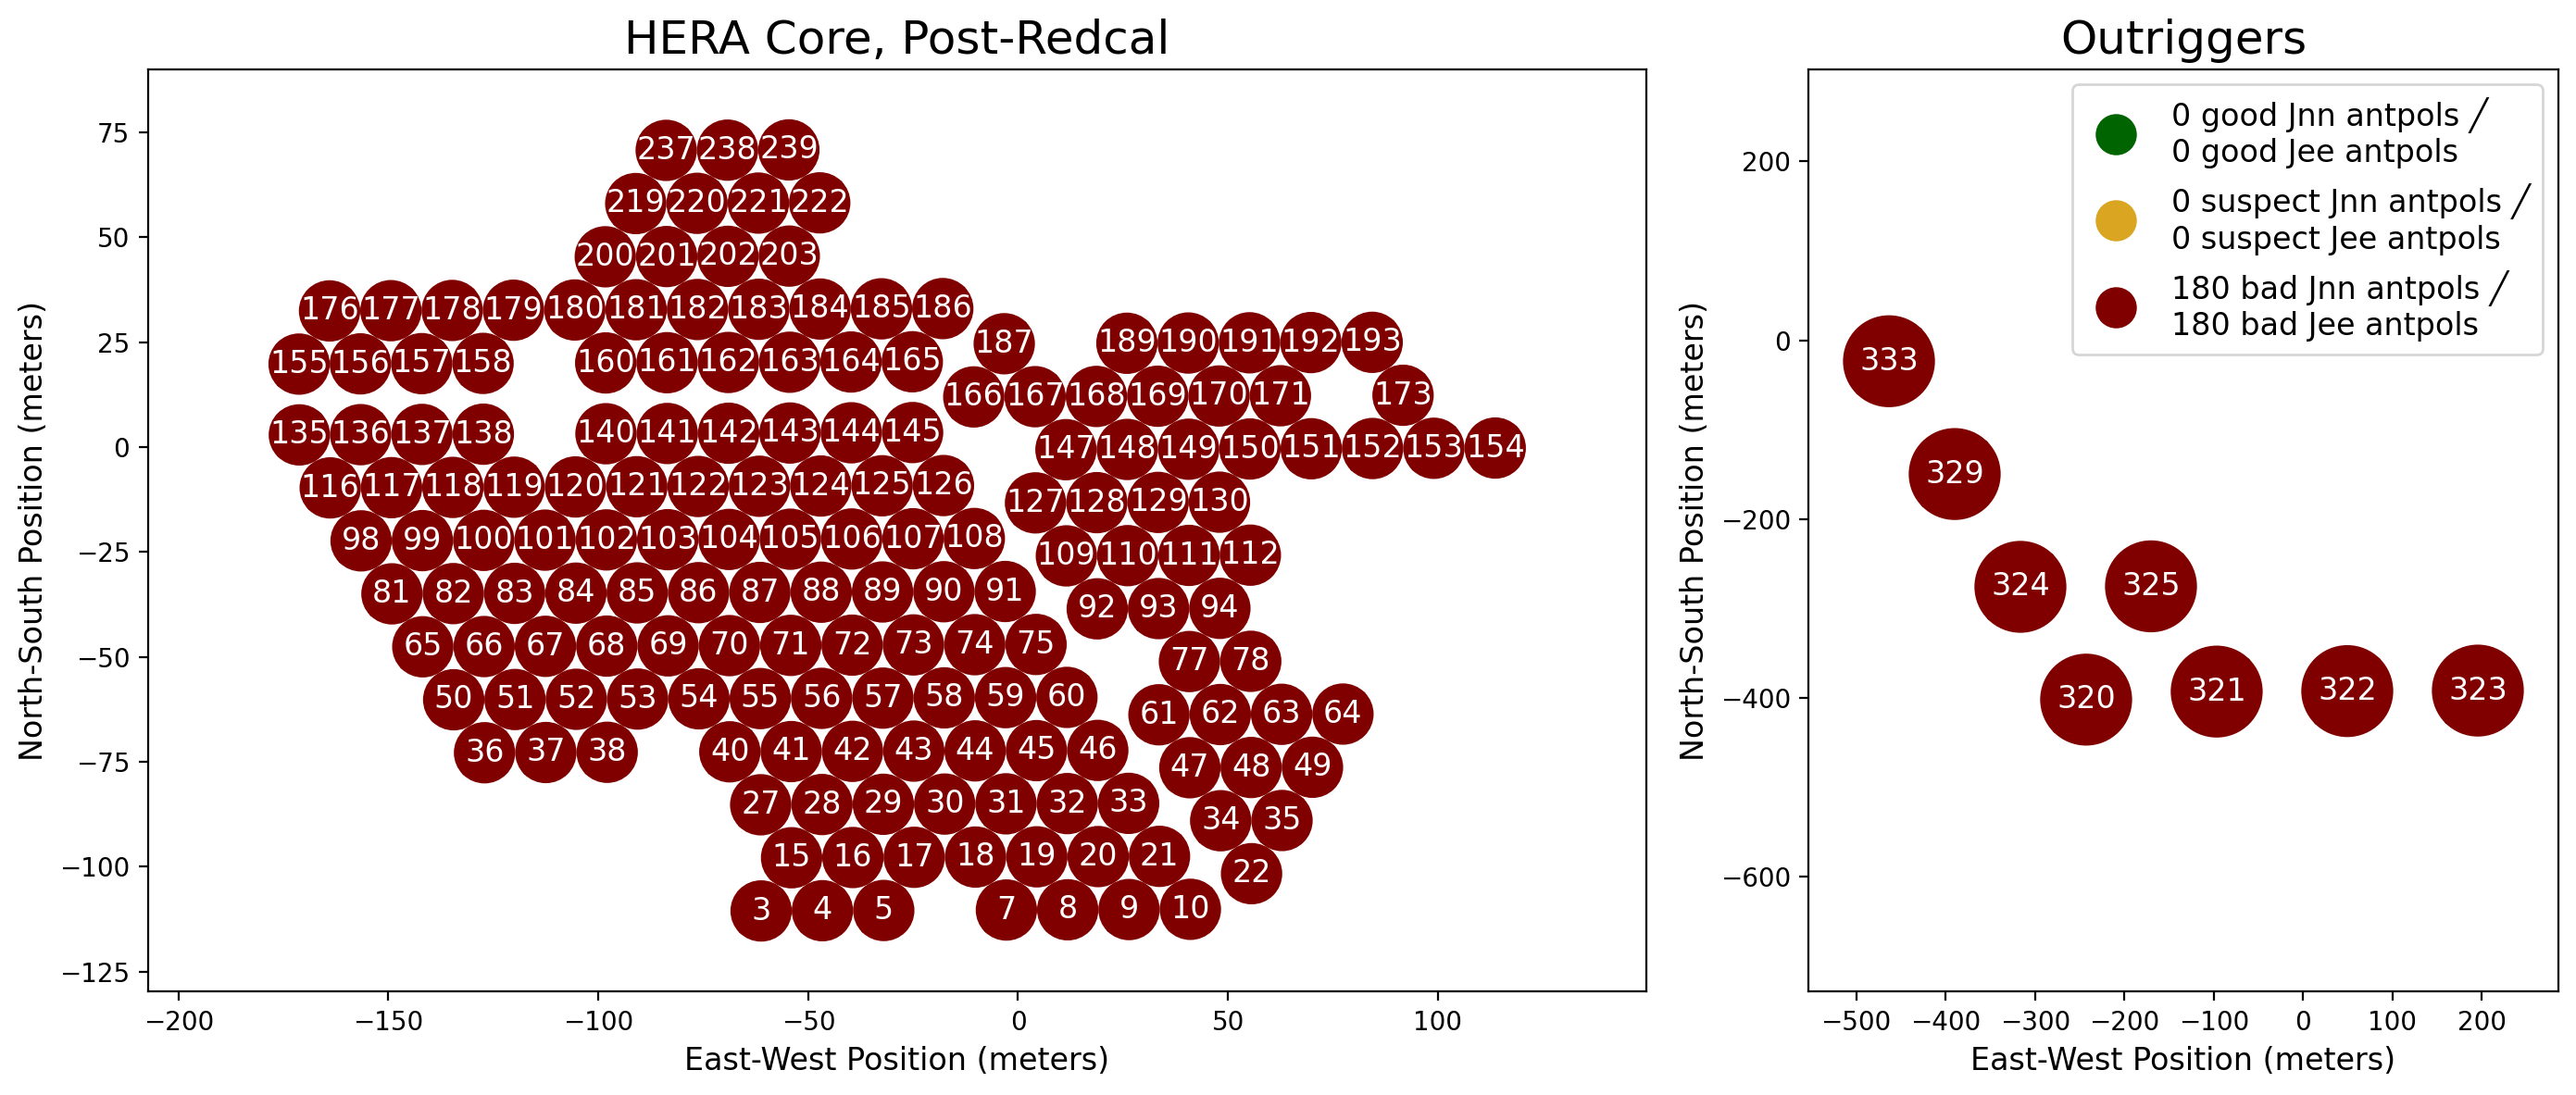

In [64]:
if PLOT: array_class_after_redcal_plot()

In [67]:
to_show = {'Antenna': [f'{ant[0]}{ant[1][-1]}' for ant in ants]}
classes = {'Antenna': [final_class[ant] if ant in final_class else '-' for ant in ants]}
to_show['Dead?'] = [{'good': 'No', 'bad': 'Yes'}[am_totally_dead[ant]] if (ant in am_totally_dead) else '' for ant in ants]
classes['Dead?'] = [am_totally_dead[ant] if (ant in am_totally_dead) else '' for ant in ants]

if not not_bad_ants:
    auto_shape_class = None  # not defined because we had no good ants to define it.
    
for title, ac in [('Low Correlation', am_corr),
                  ('Cross-Polarized', am_xpol),
                  ('Even/Odd Zeros', zeros_class),
                  ('Autocorr Power', auto_power_class),
                  ('Autocorr Slope', auto_slope_class),
                  ('RFI in Autos', auto_rfi_class),
                  ('Autocorr Shape', auto_shape_class)]:
    if ac is not None:
        to_show[title] = [f'{ac._data[ant]:.2G}' if (ant in ac._data) else '' for ant in ants]
        classes[title] = [ac[ant] if ant in ac else '' for ant in ants]
    
if not_bad_ants:
    to_show['Redcal chi^2'] = [f'{np.median(cal["chisq_per_ant"][ant]):.3G}' if (ant in cal['chisq_per_ant']) else '-' for ant in ants]
    classes['Redcal chi^2'] = [redcal_class[ant] if ant in redcal_class else '' for ant in ants]

df = pd.DataFrame(to_show)
df_classes = pd.DataFrame(classes)
colors = {'good': 'darkgreen', 'suspect': 'goldenrod', 'bad': 'maroon'}
df_colors = df_classes.applymap(lambda x: f'background-color: {colors.get(x, None)}')

table = df.style.hide_index() \
                .apply(lambda x: pd.DataFrame(df_colors.values, columns=x.columns), axis=None) \
                .set_properties(subset=['Antenna'], **{'font-weight': 'bold', 'border-right': "3pt solid black"}) \
                .set_properties(subset=df.columns[1:], **{'border-left': "1pt solid black"}) \
                .set_properties(**{'text-align': 'center', 'color': 'white'})

# *Table 1: Complete summary of per-antenna classifications*

This table summarizes the results of the various classifications schemes detailed above. 
As before, <font color='#006400'>green is good</font>, <font color='#DAA520'>yellow is suspect</font>, and <font color='#800000'>red is bad</font>. The color for each antenna (first column) is the final summary of all other classifications.
Antennas missing from redcal $\chi^2$ were excluded redundant-baseline calibration, either because they were flagged by `ant_metrics` or the even/odd zeros check, or because they would add unwanted extra degeneracies.

In [68]:
HTML(table.render())

Antenna,Dead?,Low Correlation,Cross-Polarized,Even/Odd Zeros,Autocorr Power,Autocorr Slope,RFI in Autos
3e,No,0.77,0.38,1.9E+02,5.6,0.61,0.0016
3n,No,0.77,0.38,1.9E+02,5,0.41,0.00033
4e,No,0.79,0.38,1.9E+02,4.6,0.47,0.0016
4n,No,0.76,0.38,1.9E+02,5.4,0.52,0.002
5e,No,0.79,0.36,1.9E+02,5.5,0.38,0.0042
5n,No,0.77,0.36,1.9E+02,7.2,0.44,0.0065
7e,No,0.79,0.37,1.9E+02,5.2,0.48,0.00098
7n,No,0.78,0.37,1.9E+02,5.6,0.41,0.00033
8e,No,0.76,0.4,1.9E+02,52,0.32,0.03
8n,No,0.74,0.4,1.9E+02,55,0.34,0.0059


In [69]:
# Save antenna classification table as a csv
if SAVE_RESULTS:
    for ind, col in zip(np.arange(len(df.columns), 0, -1), df_classes.columns[::-1]):
        df.insert(int(ind), col + ' Class', df_classes[col])
    df.to_csv(ANTCLASS_FILE)    

In [70]:
print('Final Ant-Pol Classification:\n\n', final_class)

Final Ant-Pol Classification:

 Jee:
----------
bad (180 antpols):
3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 200, 201, 202, 203, 219, 220, 221, 222, 237, 238, 239, 320, 321, 322, 323, 324, 325, 329, 333


Jnn:
----------
bad (180 antpols):
3, 4, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34

## Save calibration solutions

In [71]:
# update flags in omnical gains and visibility solutions
if not_bad_ants:
    for ant in cal['gf_omnical']:
        cal['gf_omnical'][ant] |= rfi_flags
    for bl in cal['vf_omnical']:
        cal['vf_omnical'][bl] |= rfi_flags

In [74]:
if SAVE_RESULTS:
    if not_bad_ants:
        hd_writer = io.HERAData(SUM_FILE)
        redcal._redcal_run_write_results(cal, hd_writer, None, OMNICAL_FILE, OMNIVIS_FILE, None, '', vispols=['ee', 'nn'],
                                         clobber=True, verbose=True, add_to_history='Producted by file_inspect notebook.')
        del hd_writer
        malloc_trim()
    else:
        # write out a dummy file that indicates that this was run, but failed.
        system(f'touch {SUM_FILE.replace(".uvh5", ".all_ants_bad")}')

## TODO: Perform nucal

## Metadata

In [ ]:
from hera_cal import __version__
print('hera_cal:', __version__)
from hera_qm import __version__
print('hera_qm:', __version__)

In [ ]:
print(f'Finished execution in {(time.time() - tstart) / 60:.2f} minutes.')